$V(x,y) = \frac{1}{2}\left(x^2+y^2\right) + \left(x^2y-\frac{y^3}{3}\right)$

In [1]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import matplotlib

font = {'size'   : 14}
matplotlib.rc('font', **font)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pImpactR.util import naff 
ny = 128
npy = 128
radi2 = 10
npt = ny*npy
nturn = 1024*2
nsteps = 1000
dt = 1.0e-3

In [3]:
def getV(x,y):
    return 0.5*(x*x+y*y) + (x*x*y - y*y*y/3.0)

In [4]:
def getClosestDiff(ref,arr):
    # ref.shape = nSample
    nMode = len(arr)
    if ref>1.0:
        ref = ref - 1.0
    for i in range(nMode):
        if arr[i]>1.0:
            arr[i]=arr[i]-1.0
    diff = np.abs(ref-arr)
    for i in range(nMode):
        if (diff[i]>0.5):
            diff[i] = 1.0 - diff[i]
    return np.min(diff)

In [5]:
def drift(x,px,y,py,dt):
    x = x + px*dt
    y = y + py*dt
    return x,y

def kick(x,px,y,py,dt):
    px = px - dt*(x +2*x*y)
    py = py - dt*(y +  x*x  -y*y)
    return px,py
    
def oneStep(x,px,y,py,dt):
    x,y = drift(x,px,y,py,0.5*dt)
    px,py = kick (x,px,y,py,    dt)
    x,y = drift(x,px,y,py,0.5*dt)
    return x,px,y,py

def multiStep(x,px,y,py,dt,nsteps):
    x,y = drift(x,px,y,py,0.5*dt)
    for i in range(nsteps-1):
        px,py = kick (x,px,y,py,dt)
        x,y   = drift(x,px,y,py,dt)
    px,py = kick (x,px,y,py,dt)
    x,y   = drift(x,px,y,py,0.5*dt)
    return x,px,y,py
    
# def checkLost(x,px,y,py):
#     ilive = x*x+y*y < radi2
#     x = x[ilive]
#     y = y[ilive]
#     px= px[ilive]
#     py= py[ilive]
#     return x,px,y,py    

In [6]:
def Init(energy):
    y = []
    py= []
    px= []
    i=0
    for y0 in np.linspace(-0.5,0.8,ny):
        for py0 in np.linspace(-0.5,0.5,npy):
            px2 = 2*energy - py0*py0 - y0*y0 + 2.0/3.0*y0**3
            if px2 >= 0.0:
                y.append(y0)
                py.append(py0)
                px.append(np.sqrt(px2))
                
    npt = len(y)
    print(npt)
    x =np.zeros(npt)
    y =np.array(y)
    px=np.array(px)
    py=np.array(py)
                
    return x,px,y,py

In [7]:
def runFoward(x,px,y,py,nturn):
    ilive = x*x+y*y < radi2
    npt = len(y)
    data = np.zeros([nturn,npt,4])
    data[0,:,0] = x[:]
    data[0,:,1] = px[:]
    data[0,:,2] = y[:]
    data[0,:,3] = py[:]
    for i in range(1,nturn):
        x,px,y,py = multiStep(x,px,y,py,dt,nsteps)
        ilive = np.logical_and(ilive,x*x+y*y < radi2)
        data[i,:,0] = x
        data[i,:,1] = px
        data[i,:,2] = y
        data[i,:,3] = py
    return data[:,ilive,:]

In [8]:
def runBackward(x,px,y,py,nturn):
    npt = len(y)
    data = np.zeros([nturn,npt,4])
    for i in range(nturn):
        x,px,y,py = multiStep(x,px,y,py,-dt,nsteps)
        data[i,:,0] = x
        data[i,:,1] = px
        data[i,:,2] = y
        data[i,:,3] = py
    return data

In [9]:
def runPoincare(energy,y,py,dt,nsample):
    px2 = 2*energy - py*py - y*y + 2.0/3.0*y**3
    if px2 < 0.0:
        raise ValueError('px*px<0')
        return 0
    px = np.sqrt(px2)
    x = 0.0
    Y = np.zeros(nsample)
    Py= np.zeros(nsample)
    Y [0] = y
    Py[0] =py
    i=1
    h=dt
    while (i<nsample):
        x,px,y,py = oneStep(x,px,y,py,h)
        if np.abs(x) < 1.0e-6:
            Y [i]= y
            Py[i]=py
            i=i+1
            h=dt
        elif x*px < 0:
            if np.abs(x) < 1.0e-5:
                h=0.001*dt
            elif np.abs(x) < 1.0e-4:
                h=0.01*dt
            elif np.abs(x) < 1.0e-3:
                h=0.1*dt
        else:
            h=dt
    return Y,Py

In [10]:
def runFB(energy,y,py,dt,nturn):
    px2 = 2*energy - py*py - y*y + 2.0/3.0*y**3
    if px2 < 0.0:
        raise ValueError('px*px<0')
        return 0
    px = np.sqrt(px2)
    x = 0.0
    
    tmp = np.zeros([nturn,4])
    data = np.zeros([nturn])
    for i in range(nturn):
        tmp[i,0] = x
        tmp[i,1] =px
        tmp[i,2] = y
        tmp[i,3] =py
        x,px,y,py = multiStep(x,px,y,py,dt,nsteps)  
    for iturn in range(1,nturn):
        x = tmp[iturn,0]
        px= tmp[iturn,1]
        y = tmp[iturn,2]
        py= tmp[iturn,3]
        for jturn in range(iturn):
            x,px,y,py = multiStep(x,px,y,py,-dt,nsteps)
        data[iturn] = np.sqrt( (x -tmp[0,0])**2
                              +(y -tmp[0,2])**2
                              +(px-tmp[0,1])**2
                              +(py-tmp[0,3])**2 )

        
    return data

In [11]:
def runFB_ave(energy,y,py,dt,nturn,ave_ratio):
    px2 = 2*energy - py*py - y*y + 2.0/3.0*y**3
    if px2 < 0.0:
        raise ValueError('px*px<0')
        return 0
    px = np.sqrt(px2)
    x = 0.0
    
    tmp = np.zeros([nturn,4])
    data = np.zeros([nturn])
    for i in range(nturn):
        tmp[i,0] = x
        tmp[i,1] =px
        tmp[i,2] = y
        tmp[i,3] =py
        x,px,y,py = multiStep(x,px,y,py,dt,nsteps)  
    for iturn in range(1,nturn):
        x = tmp[iturn,0]
        px= tmp[iturn,1]
        y = tmp[iturn,2]
        py= tmp[iturn,3]
        ave_turns = np.max([round(ave_ratio*iturn),1])
        for jturn in range(iturn):
            x,px,y,py = multiStep(x,px,y,py,-dt,nsteps)
            if iturn-jturn <= ave_turns:
                data[iturn] = data[iturn] + np.sqrt( (x -tmp[iturn-jturn-1,0])**2
                                                    +(y -tmp[iturn-jturn-1,2])**2
                                                    +(px-tmp[iturn-jturn-1,1])**2
                                                    +(py-tmp[iturn-jturn-1,3])**2 )
        data[iturn] = data[iturn]/ave_turns
    return data

In [12]:
dataF = [0]*2
dataB = [0]*2
cFMA  = [0]*2
cFB   = [0]*2
dataFB= [0]*2
dataFBave = [0]*2
poinY = [0]*2
poinPy= [0]*2
Energy= [1.0/12.0, 1.0/9.0]

# regular: E=1/12

In [13]:
n=0
energy = Energy[n]
x,px,y,py = Init(energy)
dataF[n] = runFoward  (x,px,y,py,2*nturn) 
x = dataF[n][nturn,:,0]
px= dataF[n][nturn,:,1]
y = dataF[n][nturn,:,2]
py= dataF[n][nturn,:,3]
dataB[n] = runBackward(x,px,y,py,  nturn)

6772


##### FMA

In [14]:
dummy,npt,dummy = dataF[n].shape
X = dataF[n][:,:,0] - 1j*dataF[n][:,:,1]
Y = dataF[n][:,:,2] - 1j*dataF[n][:,:,3]
tuneXbefore = np.zeros(npt)
tuneYbefore = np.zeros(npt)
Xdiff = np.zeros(npt)
Ydiff = np.zeros(npt)
for i in range(npt):
    signal = X[:nturn,i] -np.mean(X[:nturn,i])
    tuneXbefore[i],amp,dummy = naff(1,signal,window_id=1)
    signal = X[nturn:,i] -np.mean(X[nturn:,i])
    tune,amp,dummy = naff(5,signal,window_id=1)
    Xdiff[i] = getClosestDiff(tuneXbefore[i],tune)

    signal = Y[:nturn,i] -np.mean(Y[:nturn,i])
    tuneYbefore[i],amp,dummy = naff(1,signal,window_id=1)
    signal = Y[nturn:,i] -np.mean(Y[nturn:,i])
    tune,amp,dummy = naff(5,signal,window_id=1)
    Ydiff[i] = getClosestDiff(tuneYbefore[i],tune)

In [15]:
cFMA[n] = np.sqrt(Xdiff**2 +Ydiff**2)
cFMA[n] = np.log10(cFMA[n]+1.0e-6)

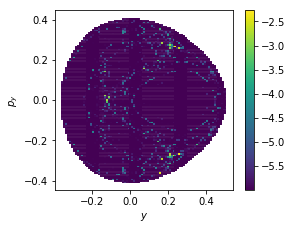

In [16]:
ymin = dataF[n][0,:,2].min()
ymax = dataF[n][0,:,2].max()
pymin= dataF[n][0,:,3].min()
pymax= dataF[n][0,:,3].max()
fig = plt.figure(figsize=[4,3.3])
f1=plt.scatter(dataF[n][0,:,2],dataF[n][0,:,3],c=cFMA[n],s=1.6,marker='s')
plt.xlim( ymin*1.1, ymax*1.1)
plt.ylim(pymin*1.1,pymax*1.1)
plt.xlabel('$y$')
plt.ylabel('$p_y$')
plt.colorbar(f1)

##### FB

In [17]:
cFB[n] = np.log10(np.sqrt(np.sum( (dataF[n][0,:,:]-dataB[n][-1,:,:])**2, axis=1)))

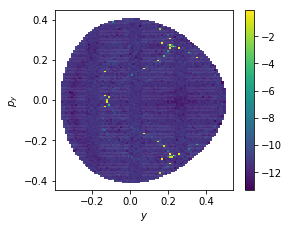

In [18]:
fig = plt.figure(figsize=[4,3.3])
f1=plt.scatter(dataF[n][0,:,2],dataF[n][0,:,3],c=cFB[n],s=1.6,marker='s')
plt.xlim( ymin*1.1, ymax*1.1)
plt.ylim(pymin*1.1,pymax*1.1)
plt.xlabel('$y$')
plt.ylabel('$p_y$')
plt.colorbar(f1)

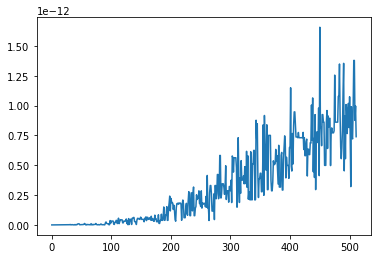

In [19]:
dataFB[n] = runFB(energy,-0.15,0.0,dt,512)
plt.plot(dataFB[n])

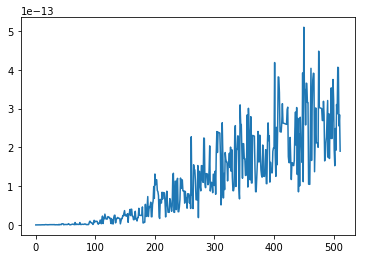

In [20]:
n=0
energy = Energy[n]
dataFBave[n] = runFB_ave(energy,-0.15,0.0,dt,512,1.0)
plt.plot(dataFBave[n])

##### Poincare

In [21]:
poinY[n],poinPy[n] = runPoincare(energy,-0.15,0.0,1.0e-3,2048*4)

Text(0,0.5,'$p_y$')

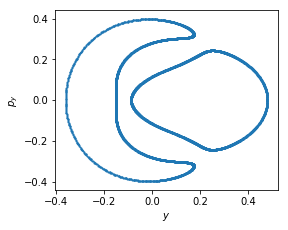

In [22]:
fig = plt.figure(figsize=[4,3.3])
plt.scatter(poinY[n],poinPy[n],s=1)
# plt.xlim( ymin*1.1, ymax*1.1)
# plt.ylim(pymin*1.1,pymax*1.1)
plt.xlabel('$y$')
plt.ylabel('$p_y$')

# regular: E=1/9

In [23]:
n=1
energy = Energy[n]
x,px,y,py = Init(energy)
dataF[n] = runFoward  (x,px,y,py,2*nturn) 
x = dataF[n][nturn,:,0]
px= dataF[n][nturn,:,1]
y = dataF[n][nturn,:,2]
py= dataF[n][nturn,:,3]
dataB[n] = runBackward(x,px,y,py,  nturn)

9220


##### FMA

In [24]:
dummy,npt,dummy = dataF[n].shape
X = dataF[n][:,:,0] - 1j*dataF[n][:,:,1]
Y = dataF[n][:,:,2] - 1j*dataF[n][:,:,3]
tuneXbefore = np.zeros(npt)
tuneYbefore = np.zeros(npt)
Xdiff = np.zeros(npt)
Ydiff = np.zeros(npt)
for i in range(npt):
    signal = X[:nturn,i] -np.mean(X[:nturn,i])
    tuneXbefore[i],amp,dummy = naff(1,signal,window_id=1)
    signal = X[nturn:,i] -np.mean(X[nturn:,i])
    tune,amp,dummy = naff(5,signal,window_id=1)
    Xdiff[i] = getClosestDiff(tuneXbefore[i],tune)

    signal = Y[:nturn,i] -np.mean(Y[:nturn,i])
    tuneYbefore[i],amp,dummy = naff(1,signal,window_id=1)
    signal = Y[nturn:,i] -np.mean(Y[nturn:,i])
    tune,amp,dummy = naff(5,signal,window_id=1)
    Ydiff[i] = getClosestDiff(tuneYbefore[i],tune)

In [25]:
cFMA[n] = np.sqrt(Xdiff**2 +Ydiff**2)
cFMA[n] = np.log10(cFMA[n]+1.0e-6)

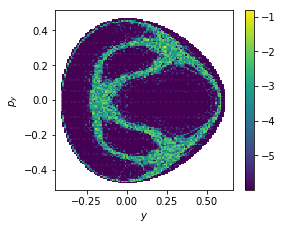

In [26]:
ymin = dataF[n][0,:,2].min()
ymax = dataF[n][0,:,2].max()
pymin= dataF[n][0,:,3].min()
pymax= dataF[n][0,:,3].max()
fig = plt.figure(figsize=[4,3.3])
f1=plt.scatter(dataF[n][0,:,2],dataF[n][0,:,3],c=cFMA[n],s=1.6,marker='s')
plt.xlim( ymin*1.1, ymax*1.1)
plt.ylim(pymin*1.1,pymax*1.1)
plt.xlabel('$y$')
plt.ylabel('$p_y$')
plt.colorbar(f1)

##### FB

In [27]:
cFB[n] = np.log10(np.sqrt(np.sum( (dataF[n][0,:,:]-dataB[n][-1,:,:])**2, axis=1)))

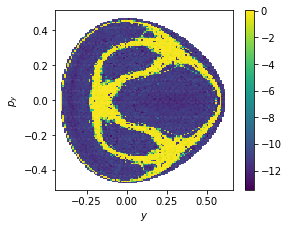

In [28]:
fig = plt.figure(figsize=[4,3.3])
f1=plt.scatter(dataF[n][0,:,2],dataF[n][0,:,3],c=cFB[n],s=1.6,marker='s')
plt.xlim( ymin*1.1, ymax*1.1)
plt.ylim(pymin*1.1,pymax*1.1)
plt.xlabel('$y$')
plt.ylabel('$p_y$')
plt.colorbar(f1)

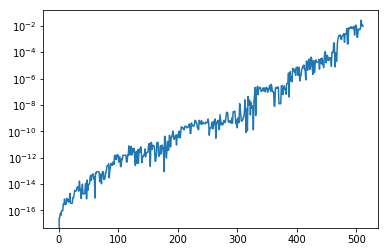

In [29]:
dataFB[n] = runFB(energy,-0.15,0.0,dt,512)
plt.semilogy(dataFB[n])

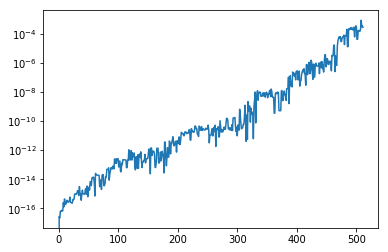

In [30]:
n=1
energy = Energy[n]
dataFBave[n] = runFB_ave(energy,-0.15,0.0,dt,512,1.0)
plt.semilogy(dataFBave[n])

##### Poincare

In [31]:
poinY[n],poinPy[n] = runPoincare(energy,-0.15,0.0,1.0e-3,2048*4)

Text(0,0.5,'$p_y$')

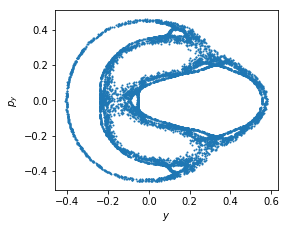

In [32]:
fig = plt.figure(figsize=[4,3.3])
plt.scatter(poinY[n],poinPy[n],s=1)
# plt.xlim( ymin*1.1, ymax*1.1)
# plt.ylim(pymin*1.1,pymax*1.1)
plt.xlabel('$y$')
plt.ylabel('$p_y$')

# comparison

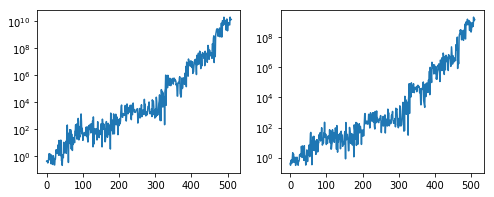

In [33]:
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.semilogy(dataFB[1][1:]/dataFB[0][1:])
plt.subplot(1,2,2)
plt.semilogy(dataFBave[1][1:]/dataFBave[0][1:])


# save data

In [13]:
HHdata = {'dataF':dataF,
          'dataB':dataB,
          'dataFB':dataFB,
          'dataFBave':dataFBave,
          'poinY':poinY,
          'poinPy':poinPy,
          'cFB':cFB,
          'cFMA':cFMA}

In [14]:
# import pickle
# pickle.dump(HHdata,open('HHdata.pickle','wb'))

# load data and plot

In [15]:
HHdata2=pickle.load(open('HHdata.pickle','rb'))

In [16]:
font = {'size'   : 14}
matplotlib.rc('font', **font)

TypeError: 'int' object is not subscriptable

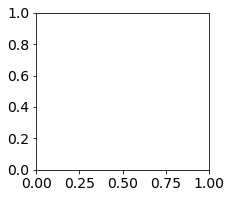

In [17]:
fig = plt.figure(figsize=[8*0.85,3.4*0.85])
plt.subplot(1,2,1)
f1=plt.scatter(dataF[0][0,:,2],dataF[0][0,:,3],c=cFMA[0],s=1.6,marker='s')
plt.xlabel('$y$')
plt.ylabel('$p_y$')
plt.yticks([-0.3,0,0.3])
plt.colorbar(f1, ticks=[-5,-3,-1])
plt.subplot(1,2,2)
f1=plt.scatter(dataF[0][0,:,2],dataF[0][0,:,3],c=cFB[0],s=1.6,marker='s')
plt.xlabel('$y$')
plt.yticks([])
plt.colorbar(f1, ticks=[-12,-6,-1])
plt.tight_layout()
plt.savefig('HH_DA_12.png',dpi=160)
plt.savefig('HH_DA_12.eps',dpi=160)

In [ ]:
fig = plt.figure(figsize=[8*0.85,3.4*0.85])
plt.subplot(1,2,1)
f1=plt.scatter(dataF[1][0,:,2],dataF[1][0,:,3],c=cFMA[1],s=1.6,marker='s')
plt.xlabel('$y$')
plt.ylabel('$p_y$')
plt.colorbar(f1, ticks=[-5,-3,-1])
plt.subplot(1,2,2)
f1=plt.scatter(dataF[1][0,:,2],dataF[1][0,:,3],c=cFB[1],s=1.6,marker='s')
plt.xlabel('$y$')
plt.yticks([])
plt.colorbar(f1, ticks=[-12,-6,-1])
plt.tight_layout()
plt.savefig('HH_DA_9.png',dpi=160)
plt.savefig('HH_DA_9.eps',dpi=160)

In [ ]:
fig = plt.figure(figsize=[8*0.85,3.7*0.85])
plt.subplot(1,2,1)
plt.scatter(HHdata2['poinY'][0],HHdata2['poinPy'][0],s=1)
plt.ylim(-0.5,0.5)
plt.xlabel('$y$')
plt.ylabel('$p_y$')
plt.subplot(1,2,2)
plt.scatter(HHdata2['poinY'][1],HHdata2['poinPy'][1],s=1)
# plt.xlim( ymin*1.1, ymax*1.1)
plt.ylim(-0.5,0.5)
plt.xlabel('$y$')
plt.tight_layout()
plt.savefig('HH_poincare.png',dpi=160)
plt.savefig('HH_poincare.eps',dpi=160)

/home/kileanhwang/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "
/home/kileanhwang/anaconda3/lib/python3.6/site-packages/matplotlib/axis.py:1086: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "
/home/kileanhwang/anaconda3/lib/python3.6/site-packages/matplotlib/axis.py:1096: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


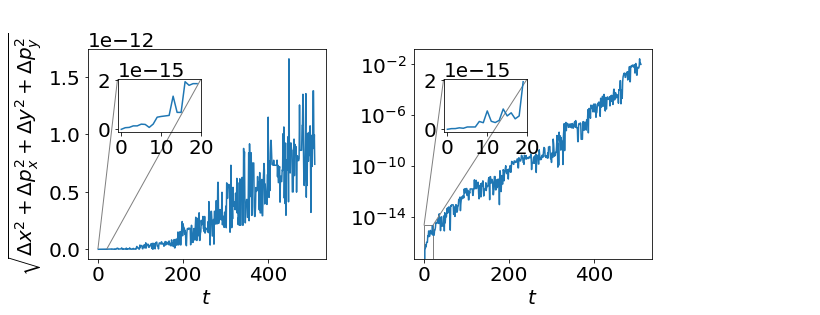

In [19]:
# from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
font = {'size'   : 20}
matplotlib.rc('font', **font)

fig = plt.figure(figsize=[8*1.2,3.7*1.2])
ax1 = plt.subplot(1,2,1)
ax1.plot(HHdata2['dataFB'][0])
plt.xlabel('$t$')
plt.ylabel(r'$\sqrt{\Delta x^2+\Delta p_x^2+\Delta y^2+\Delta p_y^2}$')
inset_axes1 = inset_axes(ax1,
                         width="35%", # width = 30% of parent_bbox
                         height="25%", # height : 1 inch
                         loc=2,
                         borderpad=1.5)
inset_axes1.plot(HHdata2['dataFB'][0][:20])
mark_inset(ax1, inset_axes1, loc1=2, loc2=1, fc="none", ec="0.5")
ax2=plt.subplot(1,2,2)
plt.semilogy(HHdata2['dataFB'][1])
# plt.xlim( ymin*1.1, ymax*1.1)
plt.xlabel('$t$')
dummy       = inset_axes(ax2,0,0,loc=2,bbox_to_anchor=(814, 329))
dummy.plot(HHdata2['dataFB'][1][:20]*0.002)
dummy.set_yticks([])
dummy.tick_params(left=False, bottom=False, labelleft=False, labelbottom=False )
# mark_inset(ax2, dummy, loc1=1, loc2=1, fc="none", ec="0.5")
inset_axes2 = inset_axes(ax2,
                         width="35%", # width = 30% of parent_bbox
                         height="25%", # height : 1 inch
                         loc=2,
                         borderpad=1.5)
inset_axes2.plot(HHdata2['dataFB'][1][:20])
mark_inset(ax2, inset_axes2, loc1=2, loc2=1, fc="none", ec="0.5")

plt.tight_layout()
plt.savefig('HH_FB_meas_overT.png')
plt.savefig('HH_FB_meas_overT.eps')

In [ ]:
def getV(x,y):
    return 0.5*(x*x+y*y) + (x*x*y - y*y*y/3.0)

In [ ]:
font = {'size'   : 10}
matplotlib.rc('font', **font)

x = np.linspace(-2.1, 2.1,512)
y = np.linspace(-2.1, 2.1,512)
X, Y = np.meshgrid(x, y)
Z = getV(X,Y)

fig, ax = plt.subplots(figsize=(5*0.5,4*0.5))
CS1 = ax.contour(X, Y, Z, levels = [1.0,2.0,3.0,4.0,6.0], colors='k', linewidths=0.4)
ax.clabel(CS1, inline=1, fontsize=8, fmt='%1.1f')
CS2 = ax.contour(X, Y, Z, levels = [0.05], colors='k', linewidths=0.4)
ax.clabel(CS2, inline=1, fontsize=8, fmt='%1.2f')
CS3 = ax.contour(X, Y, Z, levels = [0.167], colors='k', linewidths=0.4)
ax.clabel(CS3, inline=1, fontsize=8, fmt='%1.3f')
cs = ax.contourf(X, Y, Z)
plt.colorbar(cs)
plt.xticks([-2,-1,0,1,2])
plt.yticks([-2,-1,0,1,2])
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()
plt.savefig('HHpotential.png',dpi=80)
plt.savefig('HHpotential.eps',dpi=80)